In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os
from PIL import Image
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchsummary import summary
from torchvision import datasets
import urllib
import torchmetrics
from torchmetrics.classification import MulticlassAUROC
from torchmetrics.classification import MulticlassF1Score

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#modify the fully connected layer of AlexNet

alex_net = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', weights='DEFAULT')
print(alex_net)
for param in alex_net.parameters():
    param.requires_grad = False
alex_net.classifier = nn.Sequential(
    nn.Linear(in_features=9216, out_features=4096),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(in_features=4096, out_features=1024),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(in_features=1024, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=4)
)
alex_net.cuda()


Using cache found in /home/valicia/.cache/torch/hub/pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, 

In [12]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    opt.zero_grad()                    # Flush memory  
    batch_loss = loss_fn(model(x), y)  # Compute loss
    batch_loss.backward()              # Compute gradients
    opt.step()                         # Make a GD step
    
    return batch_loss.detach().cpu().numpy()

In [13]:
@torch.no_grad()
def accuracy(x, y, model):
  """
  Calculate and return the accuracy. 
  x: features
  y: labels
  Return: accuracy
  """
  model.eval()
  prediction = model(x)
  argmaxes = prediction.argmax(dim=1) # get the predicted label 
  f1 = MulticlassF1Score(num_classes=4,average=None).cuda()
  f1_score = f1(prediction,y)
  auc = MulticlassAUROC(num_classes=4, average=None, thresholds=None).cuda()
  auc_score = auc(prediction,y)
  s = torch.sum((argmaxes == y).float())/len(y)  # calculate test accuracy
  return s.cpu().numpy(),f1_score.cpu().numpy(),auc_score.cpu().numpy()

In [14]:
def plot(losses,accuracies,n_epochs):
  """
  Plot the training accuracies and losses over number of epochs 
  losses: a list of training loss
  accuracies: a list of training accuracy
  n_epochs: a list of number of epochs
  """
  plt.figure(figsize=(13,3))
  plt.subplot(121)
  plt.title('Training Loss value over epochs')
  plt.plot(np.arange(n_epochs) + 1, losses)
  plt.subplot(122)
  plt.title('Training Accuracy value over epochs')
  plt.plot(np.arange(n_epochs) + 1, accuracies)

In [15]:
def plot_f1_auc(f1,auc,n_epochs):
  """
  Plot the training accuracies and losses over number of epochs 
  losses: a list of training loss
  accuracies: a list of training accuracy
  n_epochs: a list of number of epochs
  """
  fig, axs = plt.subplots(2, 2)
  axs[0, 0].plot(np.arange(n_epochs) + 1, f1[...,0])
  axs[0, 0].set_title('Mild Demented')
  axs[0, 1].plot(np.arange(n_epochs) + 1, f1[...,1])
  axs[0, 1].set_title('Moderate Demented')
  axs[1, 0].plot(np.arange(n_epochs) + 1, f1[...,2])
  axs[1, 0].set_title('Non Demented')
  axs[1, 1].plot(np.arange(n_epochs) + 1, f1[...,3])
  axs[1, 1].set_title('Mild Demented')

  for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='F1 Score')
  
  for ax in axs.flat:
    ax.label_outer()
  
  fig2, axs2 = plt.subplots(2, 2)
  axs2[0, 0].plot(np.arange(n_epochs) + 1, auc[...,0])
  axs2[0, 0].set_title('Mild Demented')
  axs2[0, 1].plot(np.arange(n_epochs) + 1, auc[...,1])
  axs2[0, 1].set_title('Moderate Demented')
  axs2[1, 0].plot(np.arange(n_epochs) + 1, auc[...,2])
  axs2[1, 0].set_title('Non Demented')
  axs2[1, 1].plot(np.arange(n_epochs) + 1,auc[...,3])
  axs2[1, 1].set_title('Mild Demented')

  for ax in axs2.flat:
    ax.set(xlabel='Epoch', ylabel='AUC')
  
  for ax in axs2.flat:
    ax.label_outer()
  plt.plot()

In [16]:
def train(trainset, testset, model, name):
  """
  Train the model with training dataset, and return the training losses, training
    accuracies, and number of epochs. 
  trainset: the processed train data with wanted dimensions
  testset:  the processed test data with wanted dimensions
  model: a torchvision model
  name: the name of the model in string
  Return: Testing accuracy, training losses, training accuracies, and number of epochs
  """
  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  # load the data
  train_dl = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True,drop_last=True)
  test_dl = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False,drop_last=True)

  # set up loss function and optimization function
  loss_func = nn.CrossEntropyLoss()
  opt = Adam(model.parameters(), lr=1e-3)

  # train and record the loss, accuracies for each training epoch
  losses, accuracies, n_epochs = [], [], 50
  for epoch in range(n_epochs):
    running_vloss = 0.0
    print(f"Running epoch {epoch + 1} of {n_epochs}")
  
    epoch_losses, epoch_accuracies  = [], []
    for batch in train_dl:
      # calculate loss
        x, y = batch
        x, y = x.to(device), y.to(device)
        batch_loss = train_batch(x, y, model, opt, loss_func)
        epoch_losses.append(batch_loss)
    epoch_loss = np.mean(epoch_losses)

    for batch in train_dl:
      # calcualte accuracy 
        x, y = batch
        x, y = x.to(device), y.to(device)
        batch_acc, _, _ = accuracy(x, y, model)
        epoch_accuracies.append(batch_acc)
    
    epoch_accuracy = np.mean(epoch_accuracies)
    
    
    print(f"The training loss and training accuracy is {epoch_loss} and {epoch_accuracy}")
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

  # calculate the testing accuracy using the model we just trained
  epoch_accuracies = []
  batch_num = 0.0
  f1_batch, auc_batch = 0, 0
  for ix, batch in enumerate(test_dl):
      x, y = batch
      x, y = x.to(device), y.to(device)
      batch_acc, batch_f1, batch_auc = accuracy(x, y, model)
      epoch_accuracies.append(batch_acc)
      f1_batch += batch_f1
      auc_batch += batch_auc
      batch_num += 1
  print(f"batch number is {batch_num}")
  f1_batch=f1_batch/batch_num
  auc_batch=auc_batch/batch_num   
  # save the model for future uses
  torch.save(model.state_dict(), name+".pth")
  print(f"Test accuracy: {np.mean(epoch_accuracies)}")
  return np.mean(epoch_accuracies), losses, accuracies, n_epochs, f1_batch, auc_batch

In [17]:
def main():
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  # transform the images to match the ImageNet image requirementa
  transform = transforms.Compose(
      [transforms.Resize((256,256)),
       transforms.CenterCrop(224),
       transforms.RandomHorizontalFlip(0.4),
       transforms.RandomAffine(180,translate=(0.3,0.3), shear=10),
       transforms.ToTensor(),
       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
       ]) 
  trainset = torchvision.datasets.ImageFolder(root='data/train',transform=transform)

  testset = torchvision.datasets.ImageFolder(root='data/test',transform=transform)
  # a list of initialized models
  models = [alex_net]
  # the names of the models
  names = ["alex_net"]
  

  test_acc = [] # store the testing accuracy
  for model, name in zip(models,names):
    acc, losses , accuracies, n_epochs, f1_score, auc_score = train(trainset,testset,model, name)
    test_acc.append(acc)
    plot(losses, accuracies, n_epochs)
    print(f"f1 scores is {f1_score}")
    print(f"AUC is {auc_score}")
    plt.show()
  
  print(f"The test accuracy is: {test_acc}")

Running epoch 1 of 50


/home/valicia/miniconda3/envs/ml/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


The training loss and training accuracy is 1.0918910503387451 and 0.49980467557907104
Running epoch 2 of 50
The training loss and training accuracy is 0.9574235677719116 and 0.558789074420929
Running epoch 3 of 50
The training loss and training accuracy is 0.9324415326118469 and 0.534960925579071
Running epoch 4 of 50
The training loss and training accuracy is 0.9389640092849731 and 0.562304675579071
Running epoch 5 of 50
The training loss and training accuracy is 0.9142345190048218 and 0.5570312738418579
Running epoch 6 of 50
The training loss and training accuracy is 0.9185705184936523 and 0.5673828125
Running epoch 7 of 50
The training loss and training accuracy is 0.9047998189926147 and 0.5560547113418579
Running epoch 8 of 50
The training loss and training accuracy is 0.9066964983940125 and 0.559374988079071
Running epoch 9 of 50
The training loss and training accuracy is 0.9016937017440796 and 0.5658203363418579
Running epoch 10 of 50
The training loss and training accuracy is 0.

/home/valicia/miniconda3/envs/ml/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


batch number is 39.0
Test accuracy: 0.5633012652397156
f1 scores is [0.0141166  0.         0.465128   0.18976833]
AUC is [0.01432575 0.01858974 0.0471464  0.02398676]


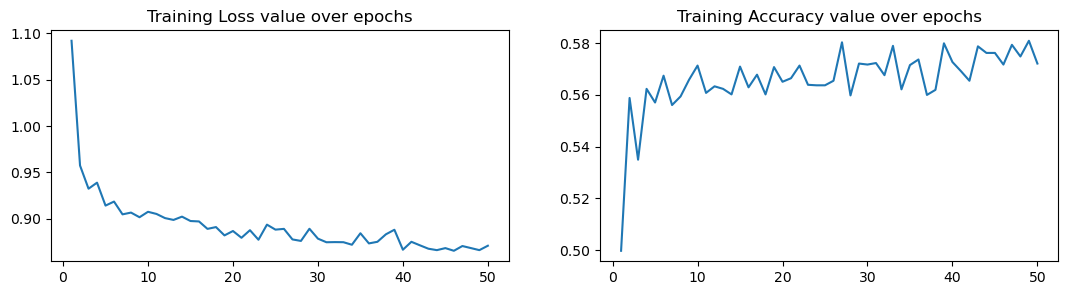

The test accuracy is: [0.56330127]


In [18]:
if __name__ == "__main__":
  main()

In [1]:
transform = transforms.Compose(
      [transforms.Resize((256,256)),
       transforms.CenterCrop(224),
       transforms.RandomHorizontalFlip(0.4),
       transforms.RandomVerticalFlip(0.2),
       transforms.RandomAffine(40),
       transforms.ToTensor(),
       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
       ]) 


alex_net.load_state_dict(torch.load("alex.pth"))
alex_net.eval()
testset = torchvision.datasets.ImageFolder(root='data/test',transform=transform)
test_dl = torch.utils.data.DataLoader(testset, batch_size=1279,shuffle=False,drop_last=True)
f1_result,auc_result = 0,0
batch_num = 0.0
for ix,batch in enumerate(test_dl):
      x,y = batch
      x,y = x.cuda(),y.cuda()
      prediction = alex_net(x)
      f1 = MulticlassF1Score(num_classes=4,average=None).cuda()
      f1_score = f1(prediction,y)
      auc = MulticlassAUROC(num_classes=4, average=None, thresholds=None).cuda()
      auc_score = auc(prediction,y)
      f1_result+=f1_score.cpu().numpy()
      auc_result+=auc_score.cpu().numpy()
      batch_num +=1
print(f"average f1 scores is {f1_result/batch_num}")
print(f"average auc is {auc_result/batch_num}")

NameError: name 'transforms' is not defined